In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 0
multi_gpus = None #[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [14]:
new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
train_sampler = SubsetRandomSampler(new_ind)

In [16]:
# define dataset

In [17]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [18]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [19]:
if zero_one_normalize:
    intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

torch.Size([1, 96, 114, 96])


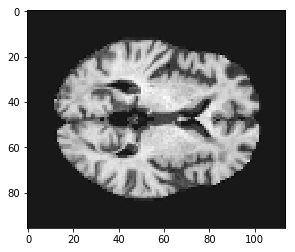

In [20]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [21]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        self.classifier_scratch = nn.Sequential(
            nn.Linear(1296, 80),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [22]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [23]:
print(net)

SixtyFourNet(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_5): Conv3d(64, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier_scratch): Sequential(
    (0): Linear(in_features=1296, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=1, bias=True)
  )
)


In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 499845


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=10,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies: {}".format(best_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 65
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [27]:
r = 0

In [28]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/20_percent/baseline/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
torch.Size([1, 96, 114, 96])
12


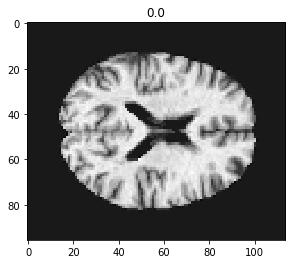

[0,    10] loss: 0.69985
Time elapsed: 0h:0m:4s
train accuracy_score: 44.60 %
train balanced_accuracy: 47.57 %
train auc_score: 47.57 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.740232
[1,    10] loss: 0.68487
Time elapsed: 0h:0m:10s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.738498
[2,    10] loss: 0.69364
Time elapsed: 0h:0m:17s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.749922
[3,    10] loss: 0.67876
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.761728
[4,    10] loss: 0.67951
Time elapsed: 0h:0m:29s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717987
[35,    10] loss: 0.67720
Time elapsed: 0h:3m:53s
train accuracy_score: 60.43 %
train balanced_accuracy: 52.83 %
train auc_score: 52.83 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731754
[36,    10] loss: 0.67648
Time elapsed: 0h:3m:59s
train accuracy_score: 56.83 %
train balanced_accuracy: 49.01 %
train auc_score: 49.01 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.754592
[37,    10] loss: 0.68863
Time elapsed: 0h:4m:5s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718618
[38,    10] loss: 0.68168
Time elapsed: 0h:4m:11s
train accuracy_score: 56.12 %
train balanced_accuracy: 51.58 %
train auc_score: 51.58 %
val accuracy_score: 40.00 %
val balanced_accu

[69,    10] loss: 0.53557
Time elapsed: 0h:8m:12s
train accuracy_score: 74.10 %
train balanced_accuracy: 71.66 %
train auc_score: 71.66 %
val accuracy_score: 74.00 %
val balanced_accuracy: 67.50 %
val auc_score: 67.50 %
Val loss: 0.511539
[70,    10] loss: 0.58743
Time elapsed: 0h:8m:19s
train accuracy_score: 65.47 %
train balanced_accuracy: 62.78 %
train auc_score: 62.78 %
val accuracy_score: 81.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.486253
[71,    10] loss: 0.55782
Time elapsed: 0h:8m:25s
train accuracy_score: 74.10 %
train balanced_accuracy: 72.88 %
train auc_score: 72.88 %
val accuracy_score: 81.00 %
val balanced_accuracy: 81.67 %
val auc_score: 81.67 %
Val loss: 0.496874
[72,    10] loss: 0.52119
Time elapsed: 0h:8m:32s
train accuracy_score: 78.42 %
train balanced_accuracy: 76.83 %
train auc_score: 76.83 %
val accuracy_score: 69.00 %
val balanced_accuracy: 72.08 %
val auc_score: 72.08 %
Val loss: 0.514263
[73,    10] loss: 0.50221
Time elapsed: 0h:8

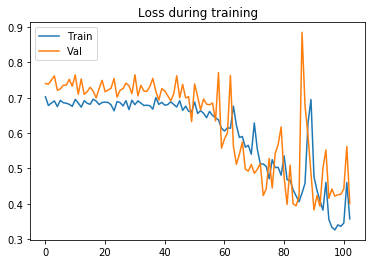

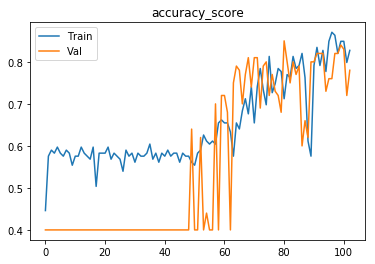

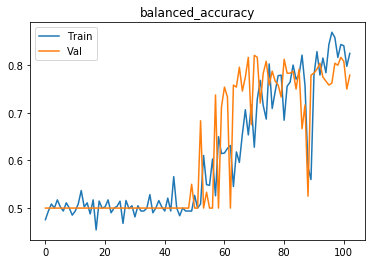

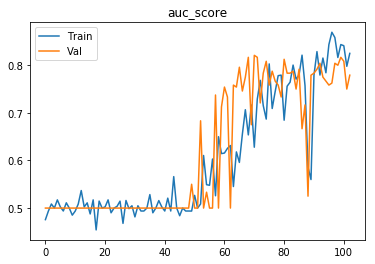

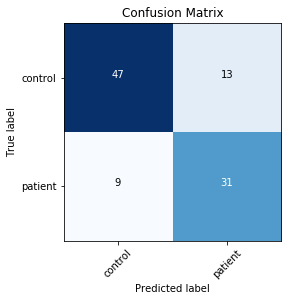

Starting trial 1
torch.Size([1, 96, 114, 96])
12


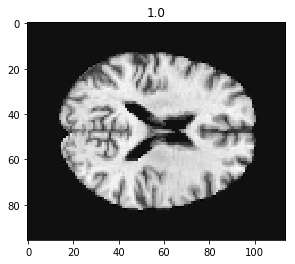

[0,    10] loss: 0.69037
Time elapsed: 0h:0m:4s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.48 %
train auc_score: 50.48 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725916
[1,    10] loss: 0.68003
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729782
[2,    10] loss: 0.68209
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716793
[3,    10] loss: 0.68676
Time elapsed: 0h:0m:23s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.63 %
train auc_score: 49.63 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719012
[4,    10] loss: 0.67869
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.738258
[35,    10] loss: 0.67531
Time elapsed: 0h:4m:27s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.748079
[36,    10] loss: 0.67687
Time elapsed: 0h:4m:33s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731957
[37,    10] loss: 0.68754
Time elapsed: 0h:4m:39s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706018
[38,    10] loss: 0.68136
Time elapsed: 0h:4m:46s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_acc

[69,    10] loss: 0.65072
Time elapsed: 0h:8m:18s
train accuracy_score: 61.15 %
train balanced_accuracy: 53.69 %
train auc_score: 53.69 %
val accuracy_score: 69.00 %
val balanced_accuracy: 73.33 %
val auc_score: 73.33 %
Val loss: 0.648304
[70,    10] loss: 0.64914
Time elapsed: 0h:8m:29s
train accuracy_score: 64.03 %
train balanced_accuracy: 60.57 %
train auc_score: 60.57 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721037
[71,    10] loss: 0.61908
Time elapsed: 0h:8m:35s
train accuracy_score: 65.47 %
train balanced_accuracy: 61.56 %
train auc_score: 61.56 %
val accuracy_score: 76.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.615286
[72,    10] loss: 0.66832
Time elapsed: 0h:8m:41s
train accuracy_score: 60.43 %
train balanced_accuracy: 55.77 %
train auc_score: 55.77 %
val accuracy_score: 72.00 %
val balanced_accuracy: 75.83 %
val auc_score: 75.83 %
Val loss: 0.609655
[73,    10] loss: 0.64076
Time elapsed: 0h:8

val accuracy_score: 80.00 %
val balanced_accuracy: 81.67 %
val auc_score: 81.67 %
Val loss: 0.436507
[104,    10] loss: 0.34339
Time elapsed: 0h:12m:40s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.33 %
train auc_score: 85.33 %
val accuracy_score: 87.00 %
val balanced_accuracy: 85.00 %
val auc_score: 85.00 %
Val loss: 0.347700
[105,    10] loss: 0.37762
Time elapsed: 0h:12m:46s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.70 %
train auc_score: 85.70 %
val accuracy_score: 85.00 %
val balanced_accuracy: 85.42 %
val auc_score: 85.42 %
Val loss: 0.381553
[106,    10] loss: 0.33708
Time elapsed: 0h:12m:56s
train accuracy_score: 87.05 %
train balanced_accuracy: 86.69 %
train auc_score: 86.69 %
val accuracy_score: 84.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.342999
[107,    10] loss: 0.30947
Time elapsed: 0h:13m:6s
train accuracy_score: 87.77 %
train balanced_accuracy: 86.81 %
train auc_score: 86.81 %
val accuracy_score: 84.00 %
val balan

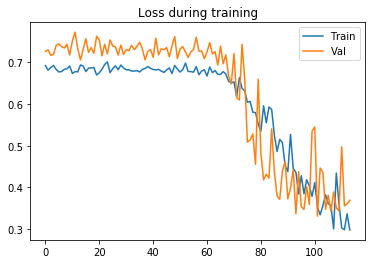

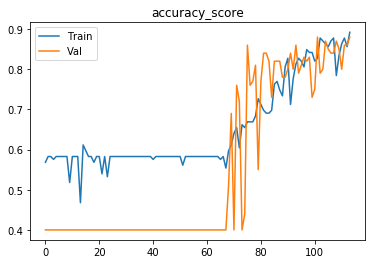

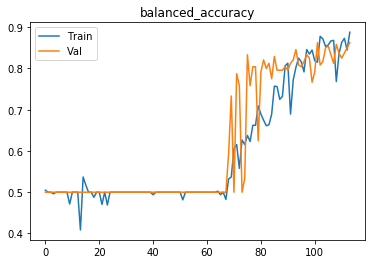

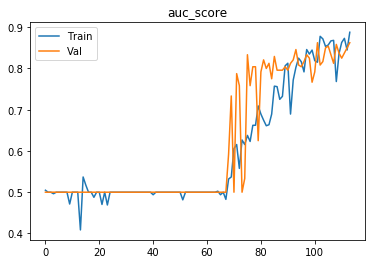

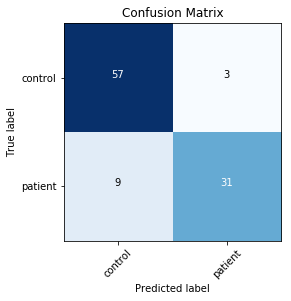

Starting trial 2
torch.Size([1, 96, 114, 96])
12


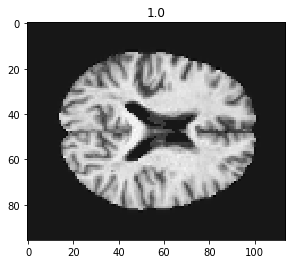

[0,    10] loss: 0.68900
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.748709
[1,    10] loss: 0.67023
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.744290
[2,    10] loss: 0.68234
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714969
[3,    10] loss: 0.69494
Time elapsed: 0h:0m:23s
train accuracy_score: 49.64 %
train balanced_accuracy: 46.02 %
train auc_score: 46.02 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716434
[4,    10] loss: 0.68353
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718492
[35,    10] loss: 0.68402
Time elapsed: 0h:4m:0s
train accuracy_score: 61.15 %
train balanced_accuracy: 53.45 %
train auc_score: 53.45 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709417
[36,    10] loss: 0.69350
Time elapsed: 0h:4m:7s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.732689
[37,    10] loss: 0.67555
Time elapsed: 0h:4m:13s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.748882
[38,    10] loss: 0.69405
Time elapsed: 0h:4m:20s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.63617
Time elapsed: 0h:7m:47s
train accuracy_score: 61.15 %
train balanced_accuracy: 54.92 %
train auc_score: 54.92 %
val accuracy_score: 76.00 %
val balanced_accuracy: 75.42 %
val auc_score: 75.42 %
Val loss: 0.569160
[70,    10] loss: 0.60671
Time elapsed: 0h:7m:54s
train accuracy_score: 64.75 %
train balanced_accuracy: 60.21 %
train auc_score: 60.21 %
val accuracy_score: 84.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.524328
[71,    10] loss: 0.58033
Time elapsed: 0h:8m:0s
train accuracy_score: 64.03 %
train balanced_accuracy: 59.59 %
train auc_score: 59.59 %
val accuracy_score: 78.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.503429
[72,    10] loss: 0.55090
Time elapsed: 0h:8m:7s
train accuracy_score: 69.78 %
train balanced_accuracy: 68.93 %
train auc_score: 68.93 %
val accuracy_score: 73.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.555427
[73,    10] loss: 0.56604
Time elapsed: 0h:8m:

val accuracy_score: 88.00 %
val balanced_accuracy: 86.25 %
val auc_score: 86.25 %
Val loss: 0.354530
[104,    10] loss: 0.34638
Time elapsed: 0h:12m:3s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.59 %
train auc_score: 84.59 %
val accuracy_score: 78.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.398289
[105,    10] loss: 0.32803
Time elapsed: 0h:12m:10s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.66 %
train auc_score: 87.66 %
val accuracy_score: 76.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.503846
[106,    10] loss: 0.34455
Time elapsed: 0h:12m:16s
train accuracy_score: 87.05 %
train balanced_accuracy: 85.71 %
train auc_score: 85.71 %
val accuracy_score: 82.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.380069
[107,    10] loss: 0.29671
Time elapsed: 0h:12m:22s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.27 %
train auc_score: 89.27 %
val accuracy_score: 77.00 %
val balan

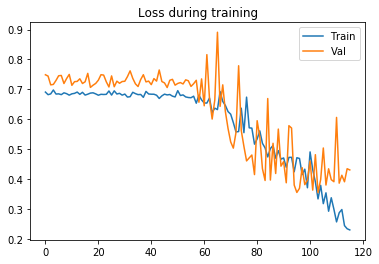

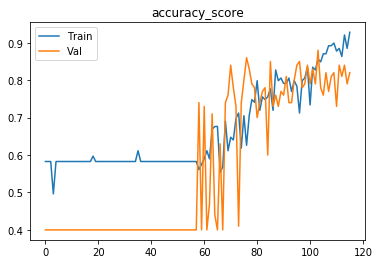

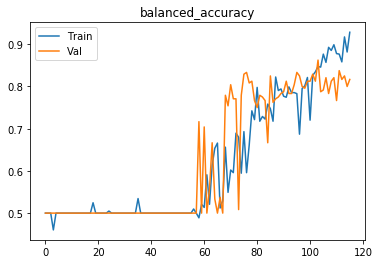

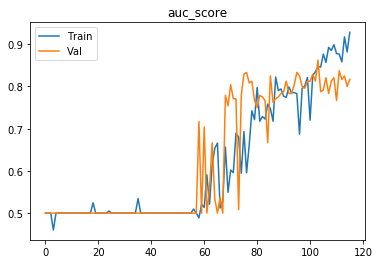

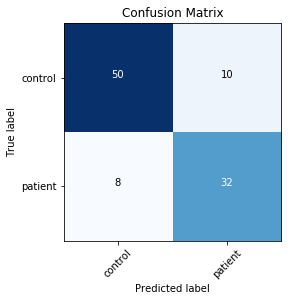

Starting trial 3
torch.Size([1, 96, 114, 96])
12


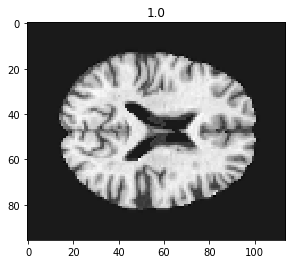

[0,    10] loss: 0.68994
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717452
[1,    10] loss: 0.68475
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743388
[2,    10] loss: 0.68209
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.739384
[3,    10] loss: 0.67911
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.715873
[4,    10] loss: 0.67917
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.765289
[35,    10] loss: 0.65752
Time elapsed: 0h:4m:13s
train accuracy_score: 56.12 %
train balanced_accuracy: 48.39 %
train auc_score: 48.39 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.715789
[36,    10] loss: 0.69881
Time elapsed: 0h:4m:20s
train accuracy_score: 50.36 %
train balanced_accuracy: 44.92 %
train auc_score: 44.92 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716876
[37,    10] loss: 0.68254
Time elapsed: 0h:4m:26s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742671
[38,    10] loss: 0.68451
Time elapsed: 0h:4m:32s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.24 %
train auc_score: 50.24 %
val accuracy_score: 40.00 %
val balanced_acc

[69,    10] loss: 0.61720
Time elapsed: 0h:8m:15s
train accuracy_score: 66.19 %
train balanced_accuracy: 63.40 %
train auc_score: 63.40 %
val accuracy_score: 73.00 %
val balanced_accuracy: 75.83 %
val auc_score: 75.83 %
Val loss: 0.549683
[70,    10] loss: 0.56496
Time elapsed: 0h:8m:22s
train accuracy_score: 67.63 %
train balanced_accuracy: 64.14 %
train auc_score: 64.14 %
val accuracy_score: 80.00 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.481775
[71,    10] loss: 0.59174
Time elapsed: 0h:8m:28s
train accuracy_score: 65.47 %
train balanced_accuracy: 63.27 %
train auc_score: 63.27 %
val accuracy_score: 78.00 %
val balanced_accuracy: 73.33 %
val auc_score: 73.33 %
Val loss: 0.484165
[72,    10] loss: 0.73452
Time elapsed: 0h:8m:34s
train accuracy_score: 58.27 %
train balanced_accuracy: 56.36 %
train auc_score: 56.36 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726074
[73,    10] loss: 0.74579
Time elapsed: 0h:8

val accuracy_score: 83.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.367641
[104,    10] loss: 0.45303
Time elapsed: 0h:12m:9s
train accuracy_score: 79.14 %
train balanced_accuracy: 78.67 %
train auc_score: 78.67 %
val accuracy_score: 79.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.437692
[105,    10] loss: 0.48340
Time elapsed: 0h:12m:15s
train accuracy_score: 77.70 %
train balanced_accuracy: 78.17 %
train auc_score: 78.17 %
val accuracy_score: 81.00 %
val balanced_accuracy: 82.92 %
val auc_score: 82.92 %
Val loss: 0.441504
[106,    10] loss: 0.42527
Time elapsed: 0h:12m:22s
train accuracy_score: 79.14 %
train balanced_accuracy: 78.18 %
train auc_score: 78.18 %
val accuracy_score: 80.00 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.369699
[107,    10] loss: 0.34597
Time elapsed: 0h:12m:28s
train accuracy_score: 85.61 %
train balanced_accuracy: 84.96 %
train auc_score: 84.96 %
val accuracy_score: 82.00 %
val balan

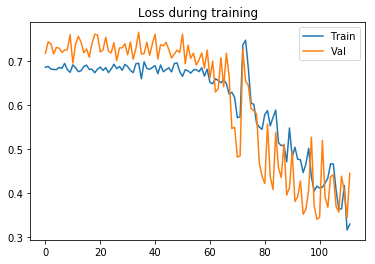

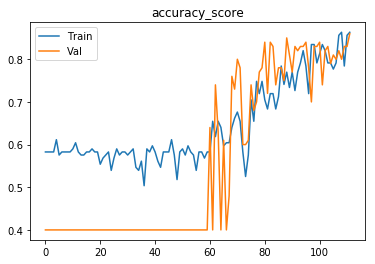

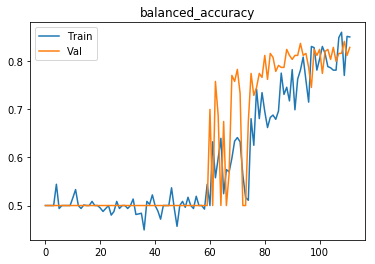

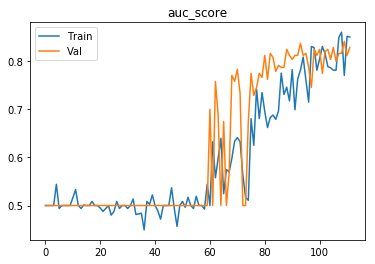

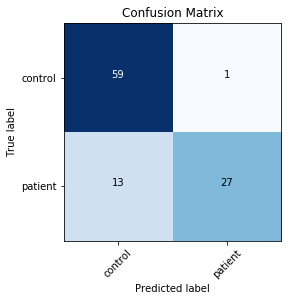

Starting trial 4
torch.Size([1, 96, 114, 96])
12


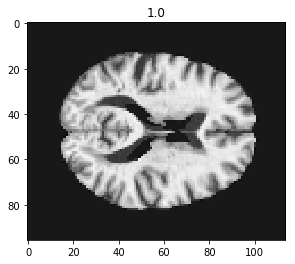

[0,    10] loss: 0.68961
Time elapsed: 0h:0m:4s
train accuracy_score: 53.96 %
train balanced_accuracy: 46.79 %
train auc_score: 46.79 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728468
[1,    10] loss: 0.69788
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726776
[2,    10] loss: 0.68485
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710685
[3,    10] loss: 0.68597
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.722853
[4,    10] loss: 0.68130
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707685
[35,    10] loss: 0.67950
Time elapsed: 0h:3m:48s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.741480
[36,    10] loss: 0.70407
Time elapsed: 0h:3m:54s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716127
[37,    10] loss: 0.67875
Time elapsed: 0h:4m:1s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712984
[38,    10] loss: 0.67838
Time elapsed: 0h:4m:7s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.57989
Time elapsed: 0h:7m:36s
train accuracy_score: 68.35 %
train balanced_accuracy: 64.76 %
train auc_score: 64.76 %
val accuracy_score: 86.00 %
val balanced_accuracy: 83.75 %
val auc_score: 83.75 %
Val loss: 0.458342
[70,    10] loss: 0.57083
Time elapsed: 0h:7m:42s
train accuracy_score: 70.50 %
train balanced_accuracy: 69.06 %
train auc_score: 69.06 %
val accuracy_score: 46.00 %
val balanced_accuracy: 55.00 %
val auc_score: 55.00 %
Val loss: 0.704879
[71,    10] loss: 0.58384
Time elapsed: 0h:7m:49s
train accuracy_score: 66.19 %
train balanced_accuracy: 63.40 %
train auc_score: 63.40 %
val accuracy_score: 76.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.499391
[72,    10] loss: 0.54119
Time elapsed: 0h:7m:55s
train accuracy_score: 69.78 %
train balanced_accuracy: 67.46 %
train auc_score: 67.46 %
val accuracy_score: 80.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.462240
[73,    10] loss: 0.55995
Time elapsed: 0h:8

val accuracy_score: 86.00 %
val balanced_accuracy: 85.00 %
val auc_score: 85.00 %
Val loss: 0.295954
[104,    10] loss: 0.31024
Time elapsed: 0h:11m:17s
train accuracy_score: 82.73 %
train balanced_accuracy: 83.72 %
train auc_score: 83.72 %
val accuracy_score: 73.00 %
val balanced_accuracy: 76.67 %
val auc_score: 76.67 %
Val loss: 0.598353
[105,    10] loss: 0.35637
Time elapsed: 0h:11m:23s
train accuracy_score: 84.17 %
train balanced_accuracy: 83.48 %
train auc_score: 83.48 %
val accuracy_score: 87.00 %
val balanced_accuracy: 85.83 %
val auc_score: 85.83 %
Val loss: 0.289668
[106,    10] loss: 0.30723
Time elapsed: 0h:11m:30s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.09 %
train auc_score: 85.09 %
val accuracy_score: 90.00 %
val balanced_accuracy: 87.92 %
val auc_score: 87.92 %
Val loss: 0.283954
[107,    10] loss: 0.29407
Time elapsed: 0h:11m:36s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.15 %
train auc_score: 89.15 %
val accuracy_score: 86.00 %
val bala

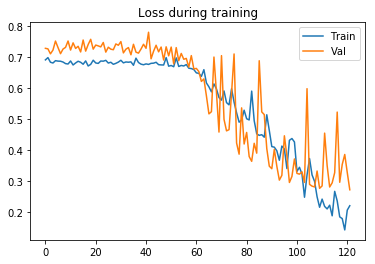

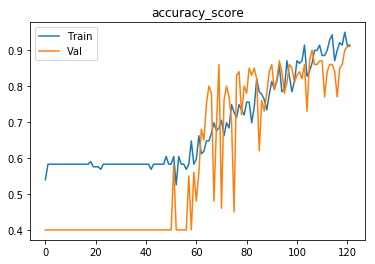

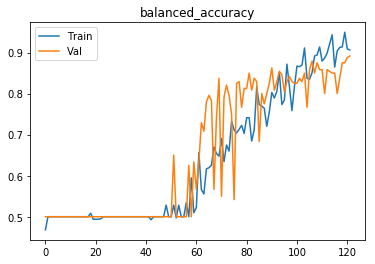

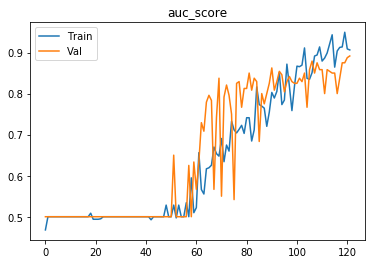

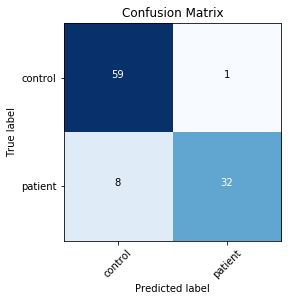

Starting trial 5
torch.Size([1, 96, 114, 96])
12


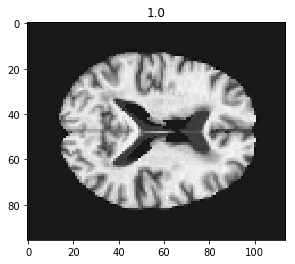

[0,    10] loss: 0.69238
Time elapsed: 0h:0m:4s
train accuracy_score: 51.08 %
train balanced_accuracy: 45.79 %
train auc_score: 45.79 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731196
[1,    10] loss: 0.68968
Time elapsed: 0h:0m:15s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718164
[2,    10] loss: 0.68420
Time elapsed: 0h:0m:25s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728634
[3,    10] loss: 0.67926
Time elapsed: 0h:0m:34s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743811
[4,    10] loss: 0.68348
Time elapsed: 0h:0m:41s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709721
[35,    10] loss: 0.67444
Time elapsed: 0h:4m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.763867
[36,    10] loss: 0.68045
Time elapsed: 0h:4m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725493
[37,    10] loss: 0.68218
Time elapsed: 0h:4m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714201
[38,    10] loss: 0.67575
Time elapsed: 0h:4m:30s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_acc

[69,    10] loss: 0.59060
Time elapsed: 0h:8m:14s
train accuracy_score: 69.06 %
train balanced_accuracy: 65.87 %
train auc_score: 65.87 %
val accuracy_score: 83.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.499268
[70,    10] loss: 0.60995
Time elapsed: 0h:8m:20s
train accuracy_score: 65.47 %
train balanced_accuracy: 65.72 %
train auc_score: 65.72 %
val accuracy_score: 78.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.478741
[71,    10] loss: 0.55400
Time elapsed: 0h:8m:27s
train accuracy_score: 66.91 %
train balanced_accuracy: 65.24 %
train auc_score: 65.24 %
val accuracy_score: 80.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.478186
[72,    10] loss: 0.58461
Time elapsed: 0h:8m:33s
train accuracy_score: 68.35 %
train balanced_accuracy: 66.48 %
train auc_score: 66.48 %
val accuracy_score: 66.00 %
val balanced_accuracy: 71.67 %
val auc_score: 71.67 %
Val loss: 0.603175
[73,    10] loss: 0.54873
Time elapsed: 0h:8

val accuracy_score: 78.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.415241
Early stopping in epoch 104
Total time elapsed: 0h:12m:5s
Writing model to disk...
Best result during training: 0.85. Saving model..
Finished fold.


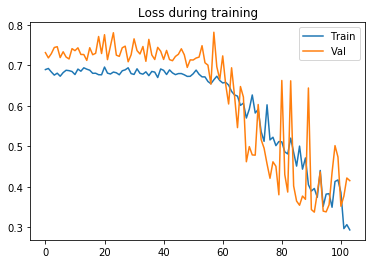

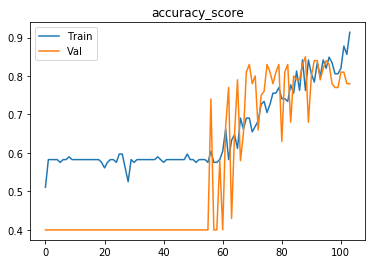

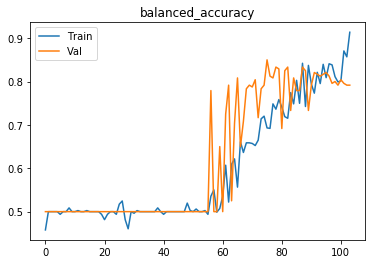

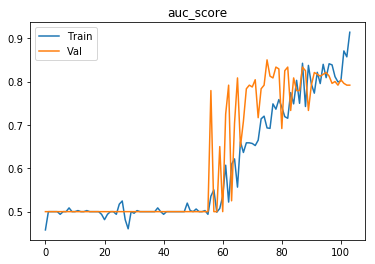

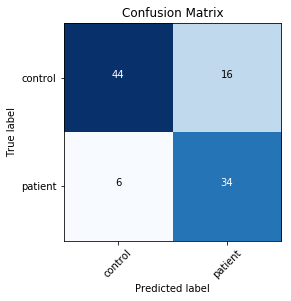

Starting trial 6
torch.Size([1, 96, 114, 96])
12


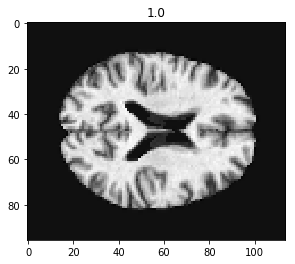

[0,    10] loss: 0.68424
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720657
[1,    10] loss: 0.68413
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729282
[2,    10] loss: 0.68425
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.753179
[3,    10] loss: 0.68828
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716474
[4,    10] loss: 0.68339
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720883
[35,    10] loss: 0.66875
Time elapsed: 0h:3m:48s
train accuracy_score: 57.55 %
train balanced_accuracy: 52.08 %
train auc_score: 52.08 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.736318
[36,    10] loss: 0.70967
Time elapsed: 0h:3m:54s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726426
[37,    10] loss: 0.68082
Time elapsed: 0h:4m:1s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729340
[38,    10] loss: 0.67726
Time elapsed: 0h:4m:7s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.58256
Time elapsed: 0h:7m:25s
train accuracy_score: 67.63 %
train balanced_accuracy: 65.37 %
train auc_score: 65.37 %
val accuracy_score: 86.00 %
val balanced_accuracy: 84.58 %
val auc_score: 84.58 %
Val loss: 0.429879
[70,    10] loss: 0.50679
Time elapsed: 0h:7m:31s
train accuracy_score: 76.98 %
train balanced_accuracy: 75.11 %
train auc_score: 75.11 %
val accuracy_score: 74.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.539897
[71,    10] loss: 0.45980
Time elapsed: 0h:7m:38s
train accuracy_score: 82.01 %
train balanced_accuracy: 81.14 %
train auc_score: 81.14 %
val accuracy_score: 80.00 %
val balanced_accuracy: 82.92 %
val auc_score: 82.92 %
Val loss: 0.481059
[72,    10] loss: 0.51997
Time elapsed: 0h:7m:44s
train accuracy_score: 74.10 %
train balanced_accuracy: 72.64 %
train auc_score: 72.64 %
val accuracy_score: 82.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.409467
[73,    10] loss: 0.45061
Time elapsed: 0h:7

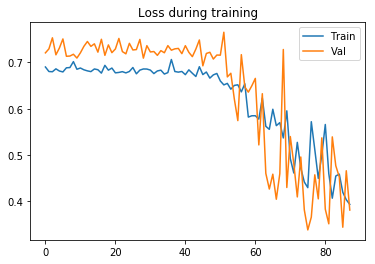

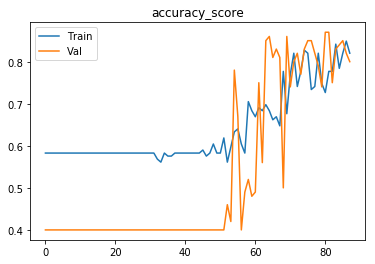

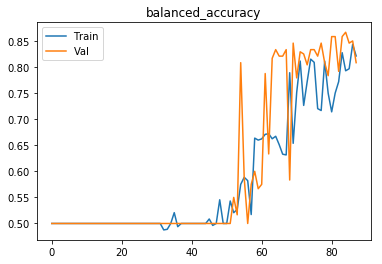

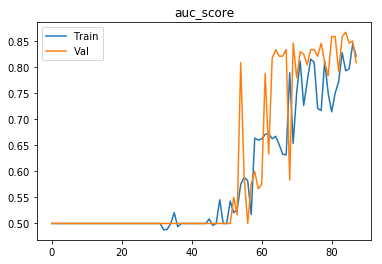

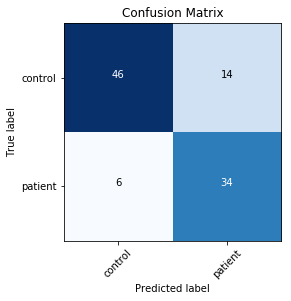

Starting trial 7
torch.Size([1, 96, 114, 96])
12


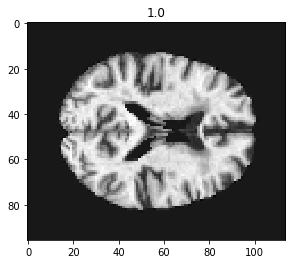

[0,    10] loss: 0.68401
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.738501
[1,    10] loss: 0.69745
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726699
[2,    10] loss: 0.68169
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.713628
[3,    10] loss: 0.68332
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717500
[4,    10] loss: 0.68651
Time elapsed: 0h:0m:29s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726420
[35,    10] loss: 0.68328
Time elapsed: 0h:3m:48s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725725
[36,    10] loss: 0.69033
Time elapsed: 0h:3m:54s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.732726
[37,    10] loss: 0.68080
Time elapsed: 0h:4m:0s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717591
[38,    10] loss: 0.68470
Time elapsed: 0h:4m:6s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.87 %
train auc_score: 49.87 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.54988
Time elapsed: 0h:7m:36s
train accuracy_score: 65.47 %
train balanced_accuracy: 62.05 %
train auc_score: 62.05 %
val accuracy_score: 81.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.451398
[70,    10] loss: 0.56812
Time elapsed: 0h:7m:42s
train accuracy_score: 69.78 %
train balanced_accuracy: 66.98 %
train auc_score: 66.98 %
val accuracy_score: 72.00 %
val balanced_accuracy: 75.83 %
val auc_score: 75.83 %
Val loss: 0.549366
[71,    10] loss: 0.54032
Time elapsed: 0h:7m:49s
train accuracy_score: 75.54 %
train balanced_accuracy: 74.85 %
train auc_score: 74.85 %
val accuracy_score: 56.00 %
val balanced_accuracy: 63.33 %
val auc_score: 63.33 %
Val loss: 0.674579
[72,    10] loss: 0.62579
Time elapsed: 0h:7m:55s
train accuracy_score: 66.91 %
train balanced_accuracy: 65.73 %
train auc_score: 65.73 %
val accuracy_score: 64.00 %
val balanced_accuracy: 70.00 %
val auc_score: 70.00 %
Val loss: 0.580355
[73,    10] loss: 0.53479
Time elapsed: 0h:8

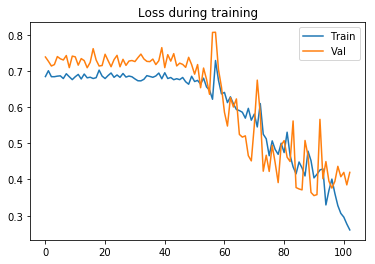

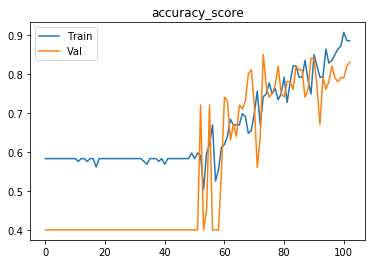

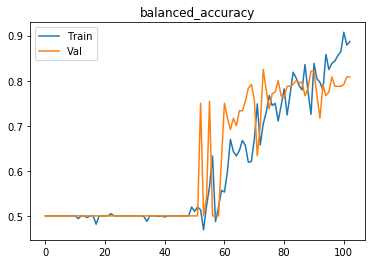

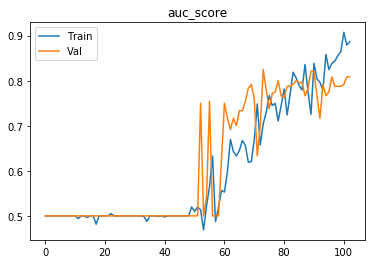

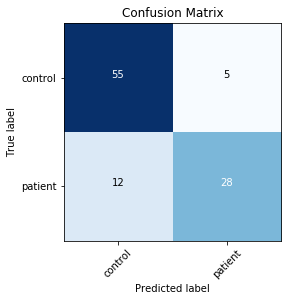

Starting trial 8
torch.Size([1, 96, 114, 96])
12


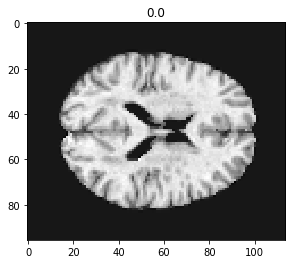

[0,    10] loss: 0.68973
Time elapsed: 0h:0m:4s
train accuracy_score: 52.52 %
train balanced_accuracy: 48.49 %
train auc_score: 48.49 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.756318
[1,    10] loss: 0.69246
Time elapsed: 0h:0m:10s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712787
[2,    10] loss: 0.68559
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.784616
[3,    10] loss: 0.69564
Time elapsed: 0h:0m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710195
[4,    10] loss: 0.68980
Time elapsed: 0h:0m:29s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703796
[35,    10] loss: 0.68404
Time elapsed: 0h:4m:0s
train accuracy_score: 61.15 %
train balanced_accuracy: 53.94 %
train auc_score: 53.94 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742898
[36,    10] loss: 0.68235
Time elapsed: 0h:4m:6s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.722172
[37,    10] loss: 0.68215
Time elapsed: 0h:4m:13s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696267
[38,    10] loss: 0.69030
Time elapsed: 0h:4m:19s
train accuracy_score: 57.55 %
train balanced_accuracy: 52.08 %
train auc_score: 52.08 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.50915
Time elapsed: 0h:7m:37s
train accuracy_score: 73.38 %
train balanced_accuracy: 71.78 %
train auc_score: 71.78 %
val accuracy_score: 75.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.509820
[70,    10] loss: 0.47127
Time elapsed: 0h:7m:44s
train accuracy_score: 79.86 %
train balanced_accuracy: 78.07 %
train auc_score: 78.07 %
val accuracy_score: 85.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.390567
[71,    10] loss: 0.47298
Time elapsed: 0h:7m:52s
train accuracy_score: 76.26 %
train balanced_accuracy: 75.71 %
train auc_score: 75.71 %
val accuracy_score: 80.00 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.390595
[72,    10] loss: 0.48929
Time elapsed: 0h:7m:59s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.89 %
train auc_score: 71.89 %
val accuracy_score: 74.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.521921
[73,    10] loss: 0.47589
Time elapsed: 0h:8

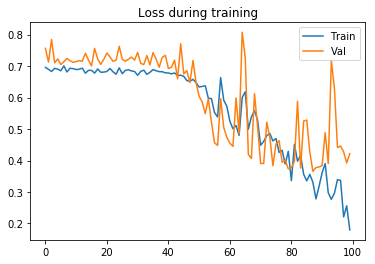

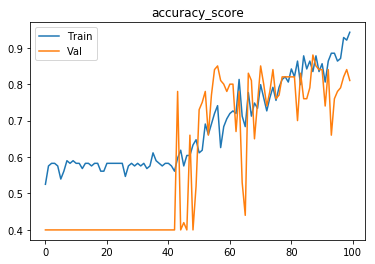

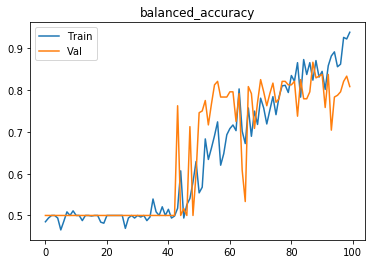

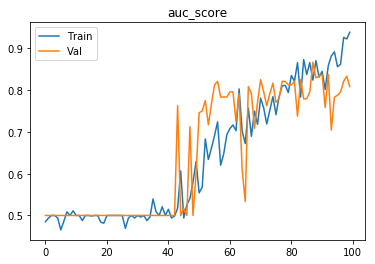

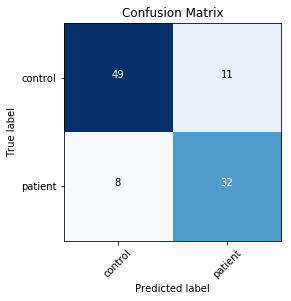

Starting trial 9
torch.Size([1, 96, 114, 96])
12


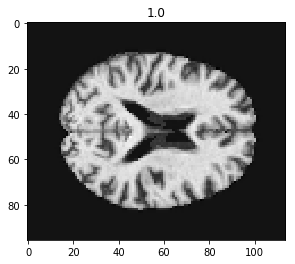

[0,    10] loss: 0.68657
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.766396
[1,    10] loss: 0.68641
Time elapsed: 0h:0m:14s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.739674
[2,    10] loss: 0.67969
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718890
[3,    10] loss: 0.68504
Time elapsed: 0h:0m:34s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723253
[4,    10] loss: 0.68752
Time elapsed: 0h:0m:40s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.747729
[35,    10] loss: 0.67742
Time elapsed: 0h:4m:23s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729353
[36,    10] loss: 0.67737
Time elapsed: 0h:4m:30s
train accuracy_score: 58.99 %
train balanced_accuracy: 51.11 %
train auc_score: 51.11 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696319
[37,    10] loss: 0.67215
Time elapsed: 0h:4m:36s
train accuracy_score: 58.99 %
train balanced_accuracy: 51.35 %
train auc_score: 51.35 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726608
[38,    10] loss: 0.67420
Time elapsed: 0h:4m:42s
train accuracy_score: 58.99 %
train balanced_accuracy: 52.58 %
train auc_score: 52.58 %
val accuracy_score: 40.00 %
val balanced_acc

[69,    10] loss: 0.47394
Time elapsed: 0h:8m:5s
train accuracy_score: 76.98 %
train balanced_accuracy: 74.62 %
train auc_score: 74.62 %
val accuracy_score: 80.00 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.406481
[70,    10] loss: 0.46824
Time elapsed: 0h:8m:12s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.40 %
train auc_score: 80.40 %
val accuracy_score: 67.00 %
val balanced_accuracy: 72.50 %
val auc_score: 72.50 %
Val loss: 0.598520
[71,    10] loss: 0.49049
Time elapsed: 0h:8m:18s
train accuracy_score: 79.14 %
train balanced_accuracy: 78.43 %
train auc_score: 78.43 %
val accuracy_score: 73.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.533717
[72,    10] loss: 0.50520
Time elapsed: 0h:8m:24s
train accuracy_score: 79.14 %
train balanced_accuracy: 77.69 %
train auc_score: 77.69 %
val accuracy_score: 78.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.401131
[73,    10] loss: 0.43082
Time elapsed: 0h:8m

val accuracy_score: 88.00 %
val balanced_accuracy: 87.08 %
val auc_score: 87.08 %
Val loss: 0.376570
[104,    10] loss: 0.23772
Time elapsed: 0h:12m:1s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.03 %
train auc_score: 89.03 %
val accuracy_score: 89.00 %
val balanced_accuracy: 87.50 %
val auc_score: 87.50 %
Val loss: 0.385685
[105,    10] loss: 0.19743
Time elapsed: 0h:12m:7s
train accuracy_score: 92.09 %
train balanced_accuracy: 91.74 %
train auc_score: 91.74 %
val accuracy_score: 88.00 %
val balanced_accuracy: 87.08 %
val auc_score: 87.08 %
Val loss: 0.389772
Early stopping in epoch 106
Total time elapsed: 0h:12m:9s
Writing model to disk...
Best result during training: 0.89. Saving model..
Finished fold.


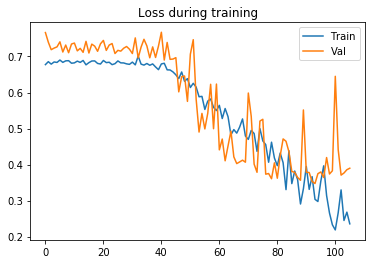

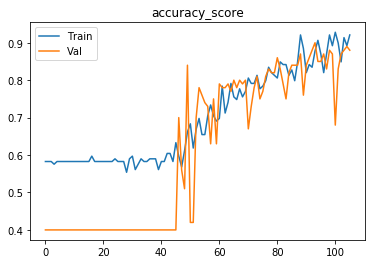

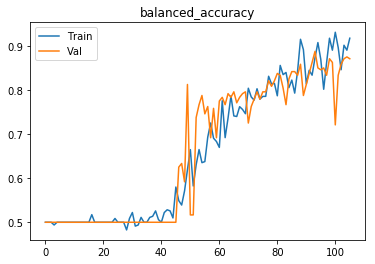

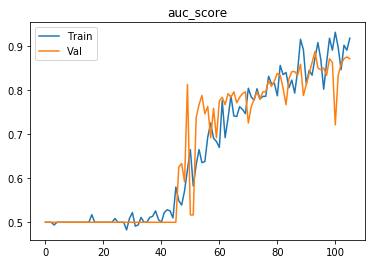

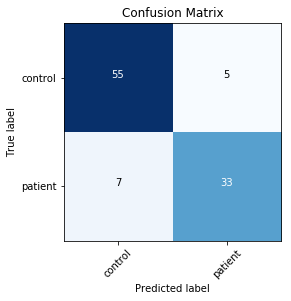

################################
################################
All accuracies: [0.7791666666666667, 0.8625, 0.8166666666666668, 0.8291666666666666, 0.8916666666666666, 0.7916666666666665, 0.8083333333333332, 0.8083333333333332, 0.8083333333333332, 0.8708333333333332]
Best accuracies: [0.8208333333333333, 0.8625, 0.8625, 0.8416666666666667, 0.8916666666666666, 0.85, 0.8666666666666667, 0.825, 0.8666666666666667, 0.8875]
Best accuracies mean: 0.8574999999999999 All :[0.8208333333333333, 0.8625, 0.8625, 0.8416666666666667, 0.8916666666666666, 0.85, 0.8666666666666667, 0.825, 0.8666666666666667, 0.8875]
0.8266666666666668
0.03472111109333278


In [25]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [26]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [40]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=True
)

In [41]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [42]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.7890034364261169
Fold 1
0.7699656357388316
Fold 2
0.8193814432989691
Fold 3
0.786872852233677
Fold 4
0.7914776632302405
Fold 5
0.7956701030927835
Fold 6
0.7338144329896907
Fold 7
0.8548453608247423
Fold 8
0.8148453608247423
Fold 9
0.8151202749140893
######## Final results ########
          0
0  0.789003
1  0.769966
2  0.819381
3  0.786873
4  0.791478
5  0.795670
6  0.733814
7  0.854845
8  0.814845
9  0.815120
Balanced accuracy mean 79.71 %
